In [17]:
from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np


def read_pcap(filename, max_packets=2000):
    # 1) Read all packets from a file
    packets = rdpcap(filename)

    stamps = []
    # 2) Iterate and inspect
    for pkt in packets:
        # Print a one‐line summary (timestamp, layers, lengths…)
        # If you want raw layers, for example IP/TCP:
        if pkt.haslayer("TCP"):
            tcp = pkt["TCP"]
            for option in tcp.options:
                if option[0] == "Timestamp":
                    tsval = option[1][0]
                    stamps.append(tsval)

    stamps = np.array(stamps)
    print(f"{filename} Number of timestamps found: {len(stamps)}")
    stamps -= stamps[0]  # Normalize to start from 0
    stamps[0] = 0
    data = stamps[5:max_packets + 6]  
    return data





In [2]:

# load and diff
stamps_covert = read_pcap("capture_covert.pcap")
stamps_normal = read_pcap("capture_normal.pcap")
stamps_covert_delayed10 = read_pcap("capture_covert_10msdelay.pcap")
stamps_normal_delayed10 = read_pcap("capture_normal_10msdelay.pcap")
stamps_covert_delayed20 = read_pcap("capture_covert_20msdelay.pcap")
stamps_normal_delayed20 = read_pcap("capture_normal_20msdelay.pcap")
stamps_covert_delayed100 = read_pcap("capture_covert_100msdelay.pcap")
stamps_normal_delayed100 = read_pcap("capture_normal_100msdelay.pcap")

diff_covert = np.diff(stamps_covert)
diff_normal = np.diff(stamps_normal)
diff_covert_d10 = np.diff(stamps_covert_delayed10)
diff_normal_d10 = np.diff(stamps_normal_delayed10)
diff_covert_d20 = np.diff(stamps_covert_delayed20)
diff_normal_d20 = np.diff(stamps_normal_delayed20)
diff_covert_d100 = np.diff(stamps_covert_delayed100)
diff_normal_d100 = np.diff(stamps_normal_delayed100)


def normalize(arr):
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn) if mx > mn else arr * 0


# normalize each
n_covert = normalize(diff_covert)
n_normal = normalize(diff_normal)
n_covert_d10 = normalize(diff_covert_d10)
n_normal_d10 = normalize(diff_normal_d10)
n_covert_d20 = normalize(diff_covert_d20)
n_normal_d20 = normalize(diff_normal_d20)
n_covert_d100 = normalize(diff_covert_d100)
n_normal_d100 = normalize(diff_normal_d100)

capture_covert.pcap Number of timestamps found: 6501
capture_normal.pcap Number of timestamps found: 2322
capture_covert_10msdelay.pcap Number of timestamps found: 5060
capture_normal_10msdelay.pcap Number of timestamps found: 3624
capture_covert_20msdelay.pcap Number of timestamps found: 3029
capture_normal_20msdelay.pcap Number of timestamps found: 2733
capture_covert_100msdelay.pcap Number of timestamps found: 5794
capture_normal_100msdelay.pcap Number of timestamps found: 2332


In [18]:
stamps_covert = read_pcap("capture_covert.pcap")
stamps_normal = read_pcap("capture_normal.pcap")
stamps_covert_delayed2 = read_pcap("capture_covert_2msdelay.pcap")
stamps_normal_delayed2 = read_pcap("capture_normal_2msdelay.pcap")
stamps_covert_delayed5 = read_pcap("capture_covert_5msdelay.pcap")
stamps_normal_delayed5 = read_pcap("capture_normal_5msdelay.pcap")


capture_covert.pcap Number of timestamps found: 6501
capture_normal.pcap Number of timestamps found: 2322
capture_covert_2msdelay.pcap Number of timestamps found: 9880
capture_normal_2msdelay.pcap Number of timestamps found: 6075
capture_covert_5msdelay.pcap Number of timestamps found: 6748
capture_normal_5msdelay.pcap Number of timestamps found: 2808


In [20]:
import numpy as np
from scipy.stats import binomtest, chisquare

# --------------------------------------------------
# 1.  Helpers
# --------------------------------------------------
def lsb(arr):
    """Return least‑significant bit (0/1) for every integer in *arr*."""
    return np.asarray(arr, dtype=np.uint64) & 1

def monobit_test(bits):
    """NIST SP 800‑22 frequency test (binomial)."""
    n1 = bits.sum()
    n  = bits.size
    p  = binomtest(k=n1, n=n, p=0.5, alternative="two-sided").pvalue
    return p, n1, n

def chi_square_k2(bits):
    """
    Chi‑square test on 2‑bit symbols (00, 01, 10, 11).
    Expected probability for each symbol = 0.25.
    """
    if len(bits) % 2:
        bits = bits[:-1]                       # make length even

    # little‑endian combine: symbol = b0 + 2*b1
    weights = np.array([1, 2], dtype=np.uint8)
    symbols = bits.reshape(-1, 2).dot(weights).astype(np.int64)

    counts  = np.bincount(symbols, minlength=4)
    chi2, p = chisquare(counts, f_exp=np.full(4, len(symbols) / 4))
    return p, counts

def shannon_entropy(bits):
    """Entropy H(X) for a Bernoulli( p = mean(bits) )."""
    p1 = bits.mean()
    p0 = 1 - p1
    eps = 1e-12
    return -(p0*np.log2(p0+eps) + p1*np.log2(p1+eps))

# --------------------------------------------------
# 2.  Load / pre‑process
# --------------------------------------------------
datasets = {
    "normal"          : lsb(stamps_normal),
    "covert"          : lsb(stamps_covert),
    "normal + 2 ms"   : lsb(stamps_normal_delayed2),
    "covert + 2 ms"   : lsb(stamps_covert_delayed2),
    "normal + 5 ms"   : lsb(stamps_normal_delayed5),
    "covert + 5 ms"   : lsb(stamps_covert_delayed5),
}

# --------------------------------------------------
# 3.  Run the three tests and print a compact table
# --------------------------------------------------
print(f"{'set':14}  monobit‑p  chi‑sq‑p   entropy  ones/total")
for name, bits in datasets.items():
    p_freq, n1, n   = monobit_test(bits)
    p_chi, counts   = chi_square_k2(bits)
    H               = shannon_entropy(bits)
    print(f"{name:14}  {p_freq:9.3g}  {p_chi:9.3g}   {H:6.3f}   {n1}/{n}")
# | Column       | Interpretation                                           |
# | ------------ | -------------------------------------------------------- |
# | `monobit‑p`  | **> 0.05** → accept “fair coin”; **≪ 0.05** → biased.    |
# | `chi‑sq‑p`   | Same threshold, but on 2‑bit symbols (stricter).         |
# | `entropy`    | 1.000 bits ≈ perfectly random; lower ⇒ more predictable. |
# | `ones/total` | Raw count for a quick sanity check.                      |


set             monobit‑p  chi‑sq‑p   entropy  ones/total
normal          2.66e-149          0    0.755   1566/2001
covert              0.964    0.00563    1.000   1002/2001
normal + 2 ms       0.655      0.545    1.000   1011/2001
covert + 2 ms       0.447      0.853    1.000   1018/2001
normal + 5 ms           1      0.587    1.000   1001/2001
covert + 5 ms       0.166     0.0876    0.999   969/2001


In [ ]:
# plot in 2×2 grid, each on its own scale 0–1
n_covert = normalize(diff_covert[:100])
n_normal = normalize(diff_normal[:100])
n_covert_d10 = normalize(diff_covert_d10[:100])
n_normal_d10 = normalize(diff_normal_d10[:100])
n_covert_d20 = normalize(diff_covert_d20[:100])
n_normal_d20 = normalize(diff_normal_d20[:100])
n_covert_d100 = normalize(diff_covert_d100[:100])
n_normal_d100 = normalize(diff_normal_d100[:100])
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(n_covert, label="Covert")
axs[0, 0].plot(n_normal, label="Normal")
axs[0, 0].set_title("No Delay")
axs[0, 0].legend()

axs[0, 1].plot(n_covert_d10, label="Covert 10 ms")
axs[0, 1].plot(n_normal_d10, label="Normal 10 ms")
axs[0, 1].set_title("10 ms Delay")
axs[0, 1].legend()

axs[1, 0].plot(n_covert_d20, label="Covert 20 ms")
axs[1, 0].plot(n_normal_d20, label="Normal 20 ms")
axs[1, 0].set_title("20 ms Delay")
axs[1, 0].legend()

axs[1, 1].plot(n_covert_d100, label="Covert 100 ms")
axs[1, 1].plot(n_normal_d100, label="Normal 100 ms")
axs[1, 1].set_title("100 ms Delay")
axs[1, 1].legend()

for ax in axs.flat:
    ax.set_xlabel("Packet Index")
    ax.set_ylabel("Normalized Inter‑arrival Time")

fig.suptitle("Covert vs. Normal Traffic Across Delays", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("covert_vs_normal_traffic.png", dpi=300, bbox_inches='tight')
plt.show()


In [3]:
labels = [
    1,  
    1, 
    # 1,
    1,
    0,
    0,
    0, 
    # 0, 
]
# labels = [
#     1,  
#     0,
# ]

X = np.vstack([
    n_covert,
    n_covert_d10,
    # n_covert_d20,
    n_covert_d100,
    n_normal,
    n_normal_d10,
    n_normal_d20,
    # n_normal_d100,
])


y = np.array(labels, dtype=int)

print(X.shape) 
print(y.shape)  
print(y)        

(6, 2000)
(6,)
[1 1 1 0 0 0]


In [4]:
window_size = 2

windows = []
window_labels = []

for sample_vec, label in zip(X, y):
    # number of full windows per sample
    n_win = sample_vec.shape[0] // window_size
    # reshape into (n_win, window_size)
    reshaped = sample_vec[: n_win * window_size].reshape(n_win, window_size)
    windows.append(reshaped)
    # each window inherits the sample label
    window_labels.extend([label] * n_win)

# stack all windows: shape (8 * 200, 10)
X_windows = np.vstack(windows)
y_windows = np.array(window_labels, dtype=int)

# shuffle
perm = np.random.RandomState(42).permutation(len(y_windows))
X_shuffled = X_windows[perm]
y_shuffled = y_windows[perm]

print("Windowed data shape:", X_shuffled.shape)   # (1600, 10)
print("Labels shape:", y_shuffled.shape)          # (1600,)
print("First 10 labels:", y_shuffled[:10])


Windowed data shape: (6000, 2)
Labels shape: (6000,)
First 10 labels: [1 0 1 1 0 1 1 1 1 1]


In [118]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.10      0.04      0.06       500
           1       0.39      0.61      0.48       500

    accuracy                           0.33      1000
   macro avg       0.25      0.33      0.27      1000
weighted avg       0.25      0.33      0.27      1000



In [10]:

# your data and labels in the original order
sample_names = [
    "covert", "covert_10ms", "covert_20ms", "covert_100ms",
    "normal", "normal_10ms", "normal_20ms", "normal_100ms"
]
labels = [1, 1, 1, 1, 0, 0, 0, 0]
X = np.vstack([
    n_covert, n_covert_d10, n_covert_d20, n_covert_d100,
    n_normal, n_normal_d10, n_normal_d20, n_normal_d100,
])
y = np.array(labels, dtype=int)

window_size = 4

X_train_w, y_train_w = [], []
X_test_w,  y_test_w  = [], []

for vec, label, name in zip(X, y, sample_names):
    # chop into non-overlapping windows of length 10
    n_win = vec.shape[0] // window_size
    windows = vec[:n_win*window_size].reshape(n_win, window_size)
    window_labels = np.full(n_win, label, dtype=int)
    
    if name in ("covert_20ms", "normal_100ms"):
        # test set
        X_test_w.append(windows)
        y_test_w.append(window_labels)
    else:
        # training set
        X_train_w.append(windows)
        y_train_w.append(window_labels)

# stack them
X_train = np.vstack(X_train_w)   # shape (~1400, 10)
y_train = np.concatenate(y_train_w)

X_test  = np.vstack(X_test_w)    # shape (200 + 200 = 400, 10)
y_test  = np.concatenate(y_test_w)

# shuffle the training set
rng = np.random.RandomState(42)
perm = rng.permutation(len(y_train))
X_train, y_train = X_train[perm], y_train[perm]

print("Train:", X_train.shape, y_train.shape)
print("Test: ",  X_test.shape,  y_test.shape)


Train: (3000, 4) (3000,)
Test:  (1000, 4) (1000,)


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


X_train_lstm = X_train[..., np.newaxis]
X_test_lstm  = X_test[...,  np.newaxis]

# Build LSTM model
model = models.Sequential([
    layers.Input(shape=(X_train_lstm.shape[1], 1)),
    layers.LSTM(64),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
model.summary()
     
# Train
history = model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,953 (70.13 KB)

 Trainable params: 17,953 (70.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5406 - loss: 0.6897 - val_accuracy: 0.6717 - val_loss: 0.6699
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6981 - loss: 0.6427 - val_accuracy: 0.6750 - val_loss: 0.6024
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7409 - loss: 0.5672 - val_accuracy: 0.7000 - val_loss: 0.5804
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.5593 - val_accuracy: 0.6833 - val_loss: 0.5782
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7449 - loss: 0.5414 - val_accuracy: 0.7200 - val_loss: 0.5552
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7260 - loss: 0.5532 - val_accuracy: 0.7167 - val_loss: 0.5478
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7490 - loss: 0.5159 - val_accuracy: 0.7100 - val_loss: 0.5329
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7366 - loss: 0.5276 - val_accuracy: 0.7217 - val_loss:

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1) Get predicted probabilities and turn them into binary labels
y_pred_probs = model.predict(X_test_lstm)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

# 2) Print a classification report
print(classification_report(y_test, y_pred, target_names=["Normal","Covert"]))

# 3) Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Confusion Matrix:\n", cm)

# 4) Plot it
plt.figure()
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
ticks = [0,1]
plt.xticks(ticks, ["Normal","Covert"])
plt.yticks(ticks, ["Normal","Covert"])
for i in ticks:
    for j in ticks:
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

capture_covert.pcap Number of timestamps found: 6501
capture_normal.pcap Number of timestamps found: 2322


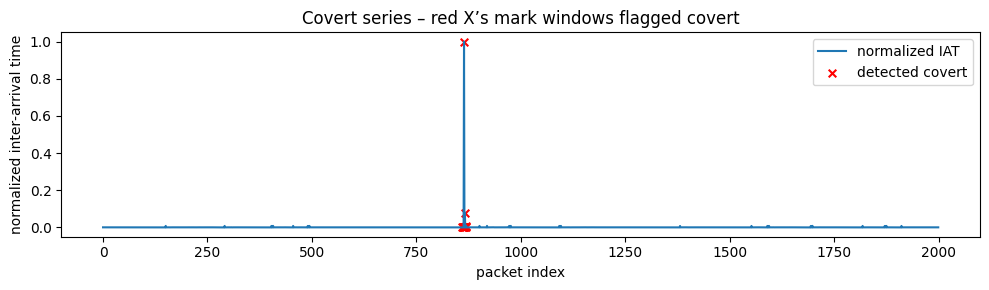

Window‑level Confusion Matrix:
 [[  0   0]
 [199   1]]
Window‑level Accuracy: 0.5%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# — your existing imports and data prep —
stamps_covert = read_pcap("capture_covert.pcap")
stamps_normal = read_pcap("capture_normal.pcap")
diff_covert  = np.diff(stamps_covert)
diff_normal  = np.diff(stamps_normal)

def normalize(arr):
    mn, mx = arr.min(), arr.max()
    return (arr - mn) / (mx - mn) if mx > mn else arr * 0

n_covert = normalize(diff_covert)
n_normal = normalize(diff_normal)

# pick one series to annotate (say the covert one)
series    = n_covert
label     = 1     # ground‐truth “covert” label for this series
window_sz = 10

# break into windows
n_win  = len(series) // window_sz
wins   = series[:n_win*window_sz].reshape(n_win, window_sz)

# compute std and threshold
stds      = wins.std(axis=1)
threshold = stds.mean() + 2*stds.std()

# detect
preds = (stds > threshold).astype(int)

# now map window detections back to sample indices
# for each window i, the samples cover indices [i*window_sz : (i+1)*window_sz)
det_idx = []
for i, p in enumerate(preds):
    if p == 1:
        start = i*window_sz
        stop  = start + window_sz
        det_idx.extend(range(start, stop))

# -- plot the original normalized IATs and overlay detections --
plt.figure(figsize=(10,3))
plt.plot(series, label="normalized IAT")  
plt.scatter(det_idx, series[det_idx],
            color='red', marker='x', s=30, label="detected covert")
plt.title("Covert series – red X’s mark windows flagged covert")
plt.xlabel("packet index")
plt.ylabel("normalized inter‑arrival time")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# — for completeness: confusion matrix & accuracy on windows —
from sklearn.metrics import confusion_matrix, accuracy_score
y_true = np.array([label]*n_win)
cm     = confusion_matrix(y_true, preds)
acc    = accuracy_score(y_true, preds)
print("Window‑level Confusion Matrix:\n", cm)
print(f"Window‑level Accuracy: {acc*100:.1f}%")
